# Sampling new models

In [1]:
import torch
from torch.utils.data import DataLoader
from guided_diffusion import *
from plotting_utils import *
from model3 import UNETv8
from tqdm import tqdm

In [2]:
BATCH_SIZE = 1
# input_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\input_id'
# output_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\target_enh'
input_folder = r'C:\Users\u_imagenes\Documents\smerino\new_testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\new_testing\target_enh'

data = CustomDataset(input_folder, output_folder, transform=True)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

# UNET v10

In [3]:
# Define beta schedule
T = 1000
# Pre-calculate different terms for closed form
beta_linear, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

Num params:  31232993


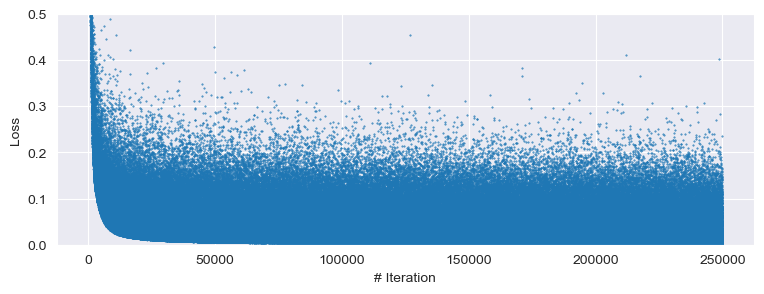

In [4]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
# save_dir = r'.\weights_v10_subset'
# training_epochs = 70
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

plt.figure(figsize=(9,3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))],loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0,0.5)
plt.show()

100%|██████████| 1000/1000 [00:19<00:00, 51.77it/s]


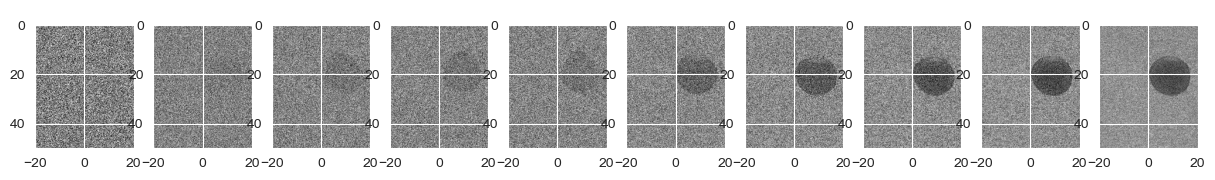

In [5]:
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

# UNET v10
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta_linear, num_intermediate=10)
show_reverse_process(intermediate_clamp)

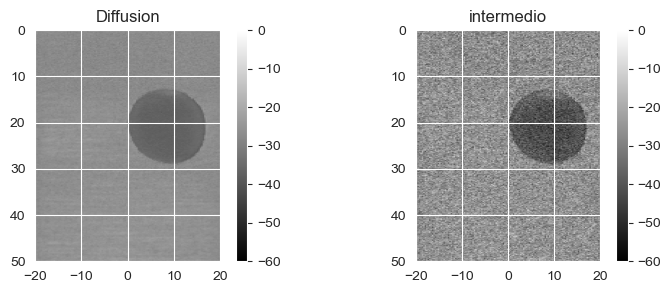

In [7]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
show_tensor_image(y_gen_clamp)
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1,2,2)
show_tensor_image(intermediate_clamp[-1].cpu())
plt.colorbar()
plt.title('Intermedio')
plt.show()

100%|██████████| 1000/1000 [00:15<00:00, 64.82it/s]


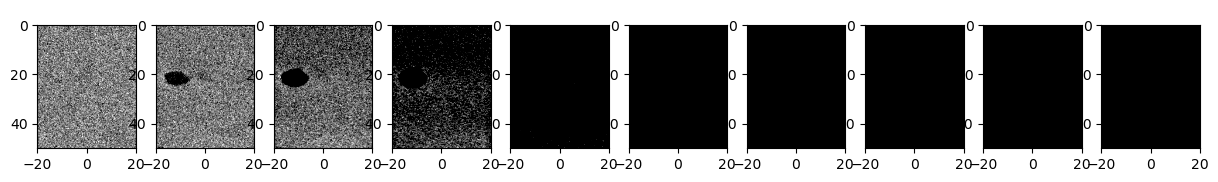

In [17]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta_linear, num_intermediate=10, clamp=False)
show_reverse_process(intermediate_clamp)


## Cosine schedule

Num params:  31232993


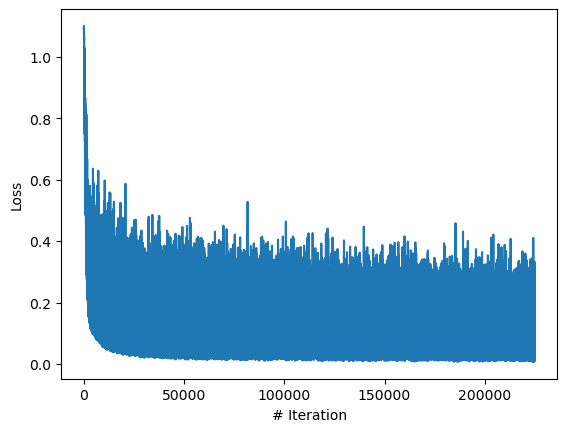

In [18]:
time_steps = 1000
beta_cosine, gamma = cosine_schedule(time_steps, device)

save_dir = r'.\weights_v10_T1000_cosine'
training_epochs = 180
model2 = UNETv10(in_channels=3, out_channels=1).to(device)
model2.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model2.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

100%|██████████| 1000/1000 [00:16<00:00, 61.77it/s]


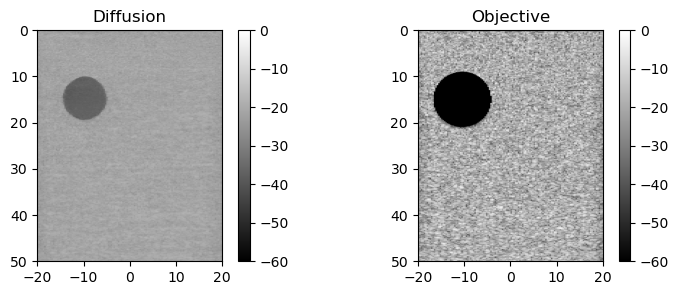

In [19]:
# x_sample, y_sample = next(iter(dataloader))
# x_sample = x_sample.to(device)
# y_sample = y_sample.to(device)
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model2, beta_cosine, num_intermediate=time_steps)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen_clamp)
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()

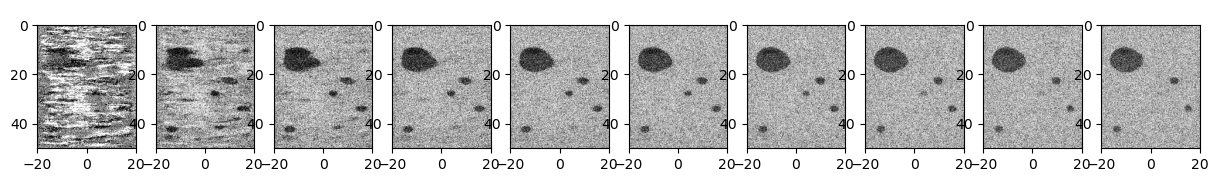

In [20]:
show_reverse_process(intermediate_clamp[:10])


In [26]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model2, beta_cosine[:990], num_intermediate=time_steps-100, clamp=False)

100%|██████████| 990/990 [00:16<00:00, 61.48it/s]


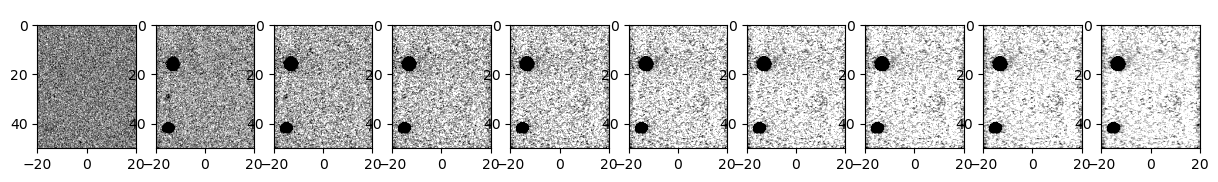

In [28]:
show_reverse_process(intermediate_clamp[::100])

## Evaluating noise prediction

Setting new batch size

In [14]:
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)

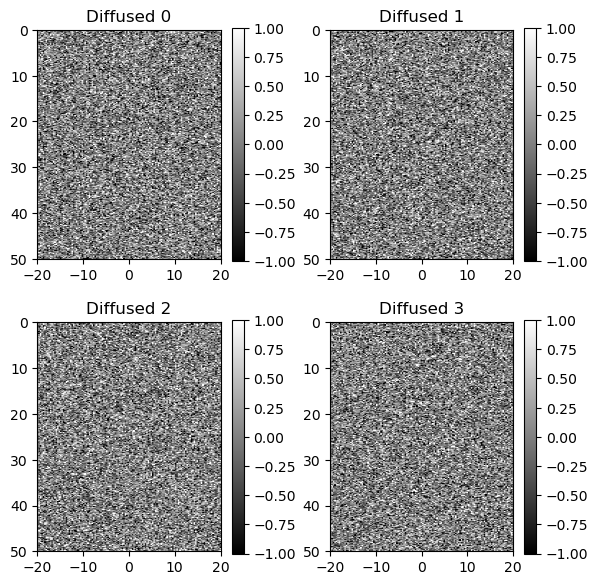

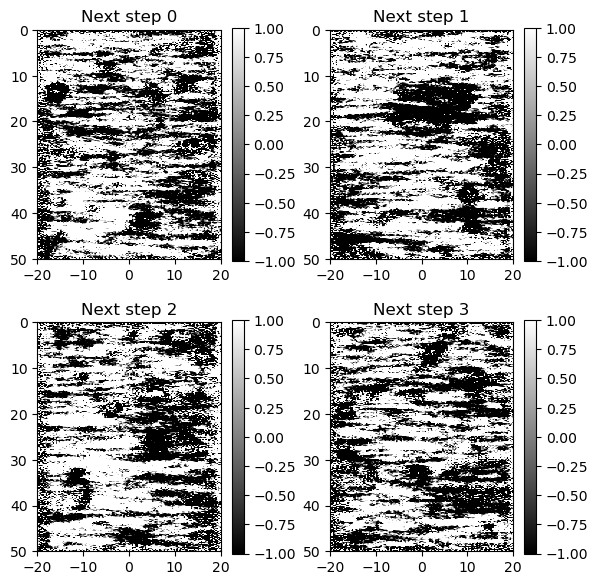

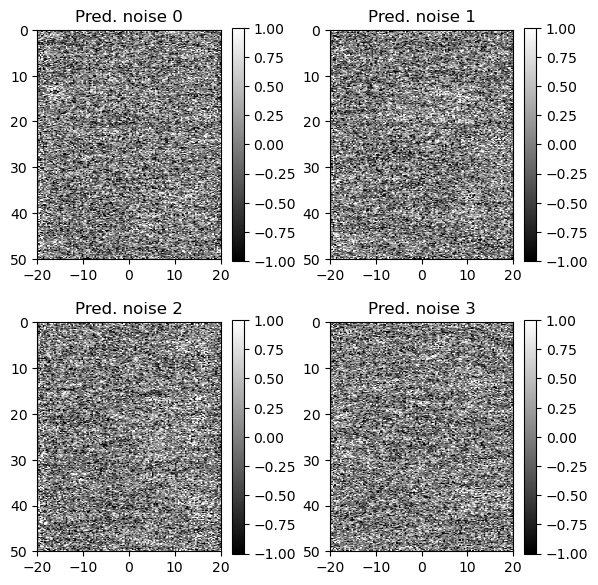

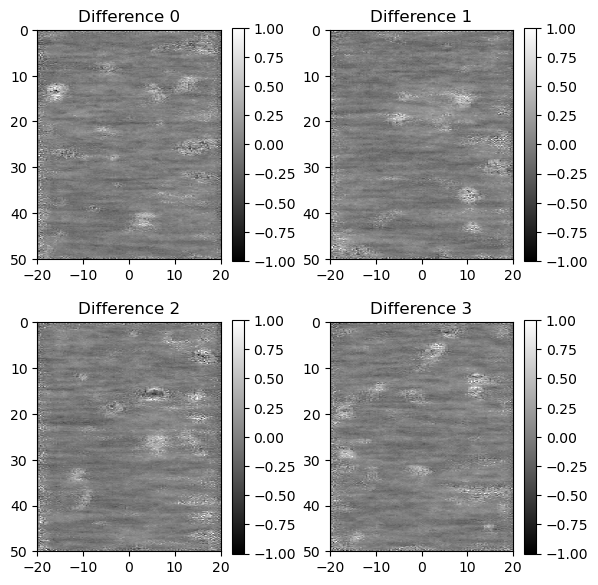

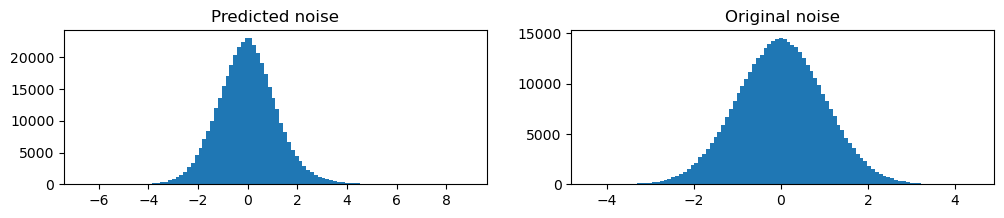

Predicted mean: -0.002279864624142647, std: 1.1949529647827148
Original mean: -0.0027430783957242966, std: 1.0005030632019043
MSE: 0.13343135255254968


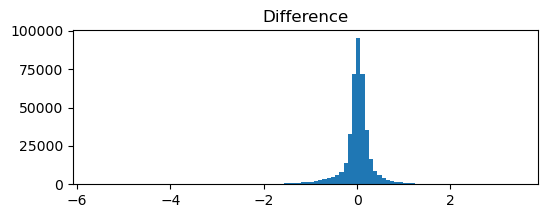

In [16]:
sample_timestep = 999
t = torch.Tensor([sample_timestep]*BATCH_SIZE).type(torch.int64).to(device)

noise = torch.randn_like(y_sample)
y_pert = forward_process(y_sample, t, gamma, noise)
input_model = torch.cat((x_sample.to(device), y_pert), 1)


plot_minibatch(y_pert, title="Diffused")
with torch.inference_mode():
    eps = model2(input_model, t)
    predicted_noise = eps.detach().to('cpu').numpy().flatten()
    original_noise = noise.detach().to('cpu').numpy().flatten()
y_next = sample_timestep_cond(x_sample, y_pert, t, model2, beta_cosine)
plot_minibatch(y_next, title="Next step")
plot_minibatch(eps, title="Pred. noise")
plot_minibatch(eps - noise, title="Difference")
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.hist(predicted_noise, 100)
plt.title("Predicted noise")

plt.subplot(122)
plt.hist(original_noise, 100)
plt.title("Original noise")
plt.show()

print(f"Predicted mean: {np.mean(predicted_noise)}, std: {np.std(predicted_noise)}")
print(f"Original mean: {np.mean(original_noise)}, std: {np.std(original_noise)}")
print(f"MSE: {np.std(original_noise - predicted_noise) ** 2}")
plt.figure(figsize=(6, 2))
plt.hist(original_noise - predicted_noise, 100)
plt.title("Difference")
plt.show()

# UNET V8

## Short schedule

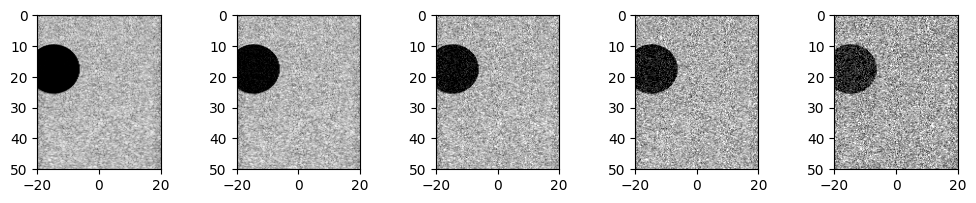

In [20]:
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

# Define beta schedule
T = 100
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=2e-2, device=device)
# Simulate forward diffusion
num_images = 5
stepsize = int(T / num_images)
plt.figure(figsize=(15, 2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    noise = torch.randn_like(y_sample)
    img = forward_process(y_sample, t, gamma, noise)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    show_tensor_image(img.cpu())
plt.show()

Num params:  32531617


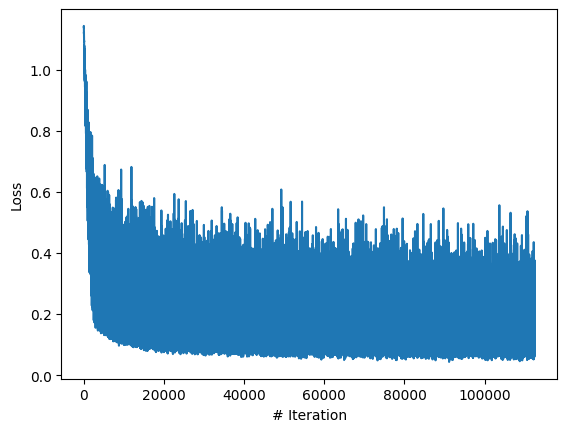

In [21]:
from model3 import UNETv8
# from model4 import UNETv10

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v8_T100'
training_epochs = 90
model = UNETv8(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


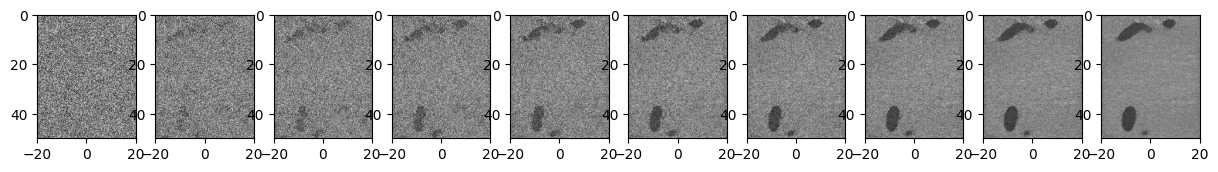

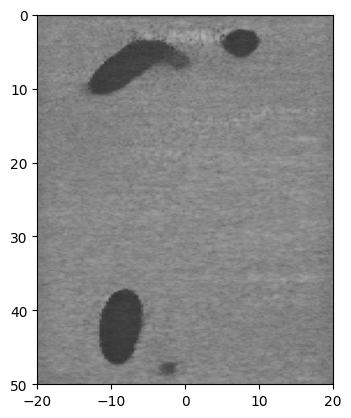

In [22]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)
show_tensor_image(y_gen_clamp)
plt.show()

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


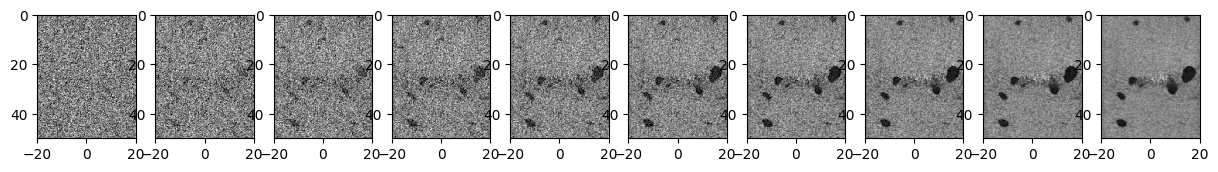

In [23]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, clamp=False, num_intermediate=10)
show_reverse_process(intermediate)

### Evaluating noise prediction

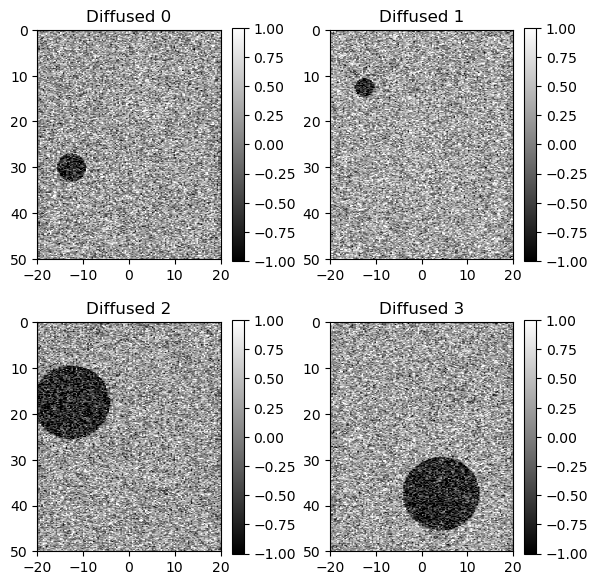

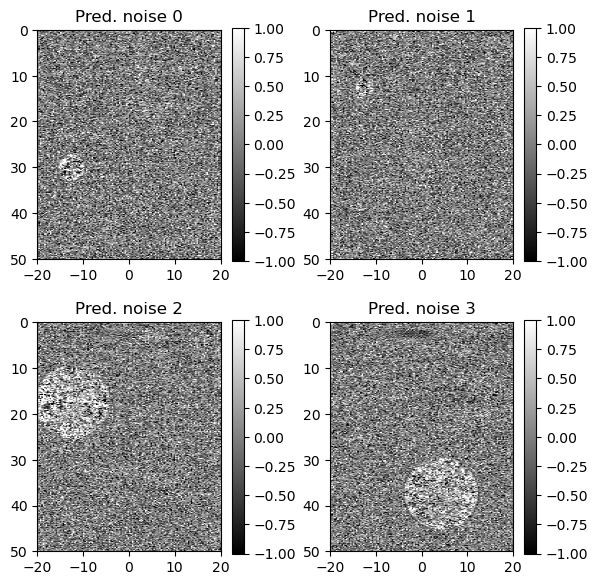

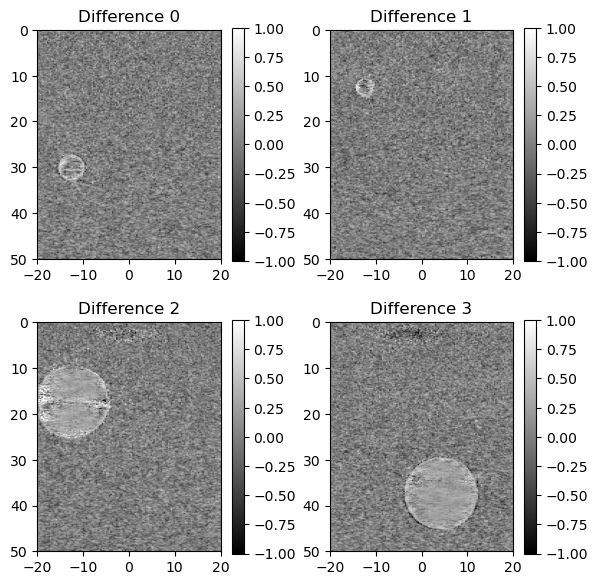

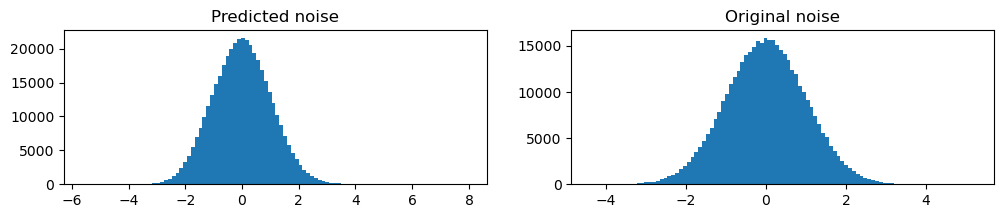

Predicted mean: -0.002434826921671629, std: 1.0272369384765625
Original mean: 0.0010850169928744435, std: 1.000817060470581
MSE: 0.0566729313647194


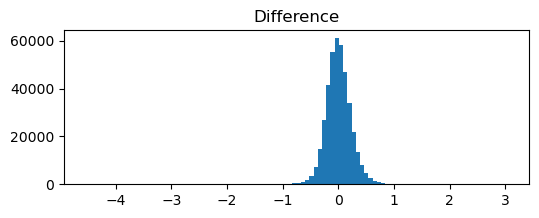

In [59]:
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)
sample_timestep = 90
t = torch.Tensor([sample_timestep]).type(torch.int64).to(device)

noise = torch.randn_like(y_sample)
y_pert = forward_process(y_sample, t, gamma, noise)
input_model = torch.cat((x_sample.to(device), y_pert), 1)

plot_minibatch(y_pert, title="Diffused")
with torch.inference_mode():
    eps = model(input_model, t)
    predicted_noise = eps.detach().to('cpu').numpy().flatten()
    original_noise = noise.detach().to('cpu').numpy().flatten()

plot_minibatch(eps, title="Pred. noise")
plot_minibatch(eps - noise, title="Difference")
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.hist(predicted_noise, 100)
plt.title("Predicted noise")

plt.subplot(122)
plt.hist(original_noise, 100)
plt.title("Original noise")
plt.show()

print(f"Predicted mean: {np.mean(predicted_noise)}, std: {np.std(predicted_noise)}")
print(f"Original mean: {np.mean(original_noise)}, std: {np.std(original_noise)}")
print(f"MSE: {np.std(original_noise - predicted_noise) ** 2}")
plt.figure(figsize=(6, 2))
plt.hist(original_noise - predicted_noise, 100)
plt.title("Difference")
plt.show()

## Long schedule

Num params:  32531617


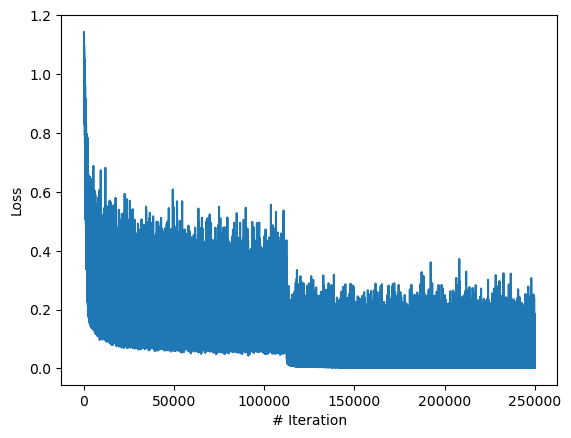

In [19]:
from model3 import UNETv8
# from model4 import UNETv10

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v8_T1000'
training_epochs = 200
model = UNETv8(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

### Shortened version

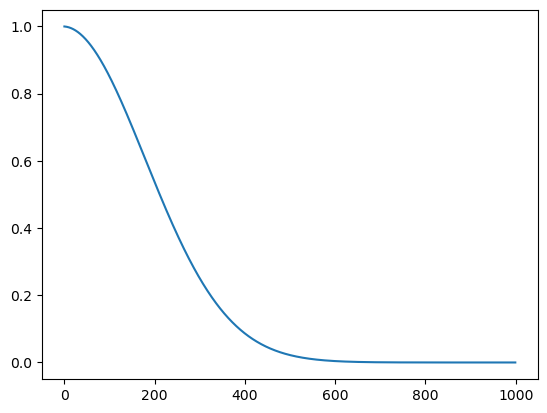

In [12]:
# x_sample, y_sample = next(iter(dataloader))
# x_sample = x_sample.to(device)
# y_sample = y_sample.to(device)

# Define beta schedule
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)
plt.plot(gamma.cpu())
plt.show()
T = 600
beta = beta[:600]
gamma = gamma[:600]

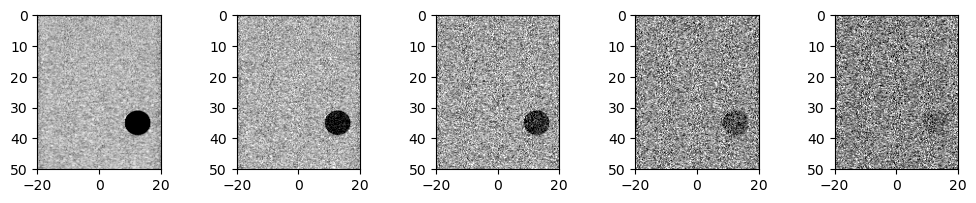

In [13]:
# Simulate forward diffusion
num_images = 5
stepsize = int(T / num_images)
plt.figure(figsize=(15, 2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    noise = torch.randn_like(y_sample)
    img = forward_process(y_sample, t, gamma, noise)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    show_tensor_image(img.cpu())
plt.show()

100%|██████████| 600/600 [00:09<00:00, 63.79it/s]


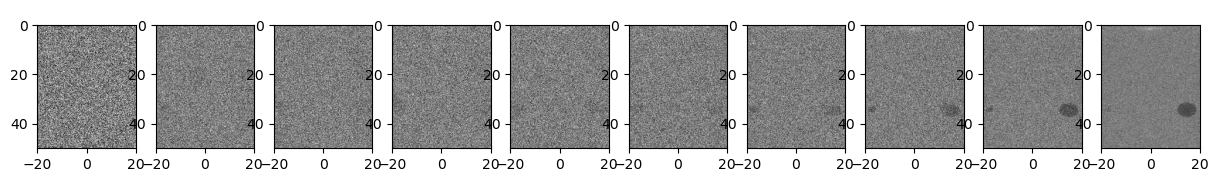

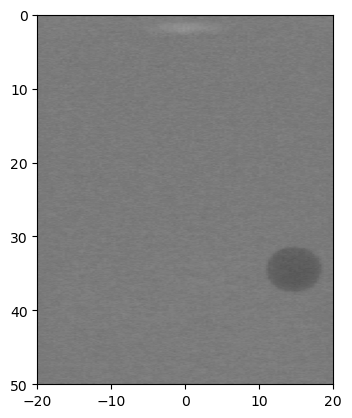

In [14]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)
show_tensor_image(y_gen_clamp)

100%|██████████| 600/600 [00:09<00:00, 66.07it/s]


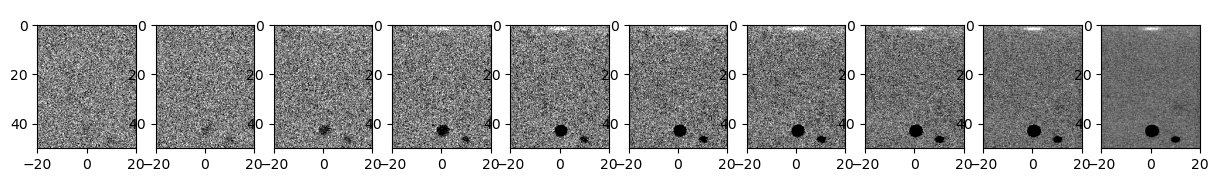

In [15]:
plt.show()
y_gen, intermediate = sample_image_cond(x_sample, model, beta, clamp=False, num_intermediate=10)
show_reverse_process(intermediate)

### Longer schedule

100%|██████████| 1000/1000 [00:15<00:00, 65.05it/s]


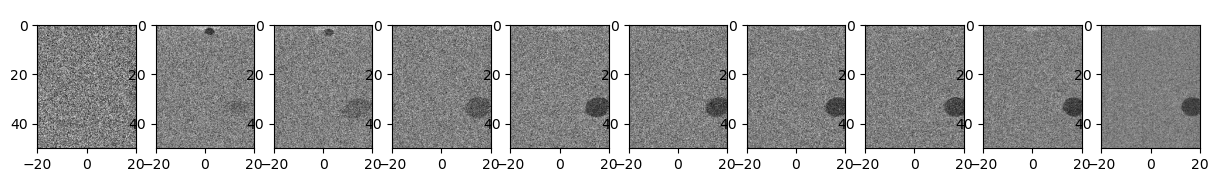

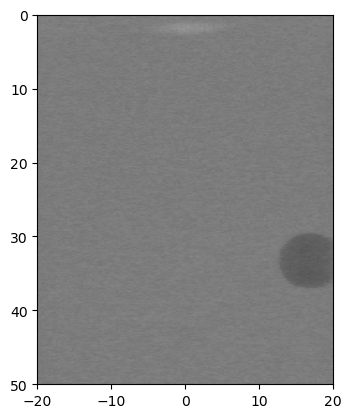

In [16]:
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)
show_tensor_image(y_gen_clamp)
plt.show()


100%|██████████| 1000/1000 [00:15<00:00, 65.30it/s]


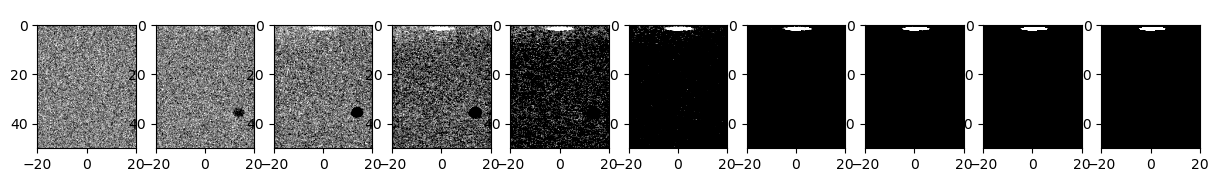

In [17]:
# NO SIRVE
y_gen, intermediate = sample_image_cond(x_sample, model, beta, clamp=False, num_intermediate=10)
show_reverse_process(intermediate)